In [1]:
# %pip install ipympl
%matplotlib inline
# #%matplotlib widget
# %pip install gpytorch
# %pip install --upgrade pip

In [2]:
# %pip install --upgrade pip

In [3]:
import sys, torch

print("Python exe:", sys.executable)
print("Torch version:", torch.__version__)

print("cuda.is_available:", torch.cuda.is_available())
print("torch.version.cuda:", torch.version.cuda)
print("build with cuda:", torch.backends.cuda.is_built())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))


import os

# Allow Intel OpenMP to load multiple times (unsafe but practical workaround)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# (Optional) also cap threads so it doesn't go crazy on CPU
os.environ["OMP_NUM_THREADS"] = "8"    # or your core count
os.environ["MKL_NUM_THREADS"] = "8"



Python exe: C:\Users\wts28\miniconda3\envs\RL\python.exe
Torch version: 2.10.0.dev20251108+cu130
cuda.is_available: True
torch.version.cuda: 13.0
build with cuda: True
device: NVIDIA GeForce RTX 5090


In [4]:
# import mujoco
# print("mujoco version:", mujoco.__version__)


Environment Setup+angle conversion

In [17]:
# =========================================================
# Cell 1 — MonsterTruck environment setup (MuJoCo, radians)
# =========================================================
import os
import math
import time
import numpy as np
import mujoco
from scipy.signal import butter, filtfilt

# ------------------- Global config -------------------
SEED = 0
rng = np.random.default_rng(SEED)

XML_PATH   = "monstertruck.xml"
FRAME_SKIP = 10                   # simulation steps per control step
ACTION_LOW, ACTION_HIGH = -1.0, 1.0

# + pitch = toward the truck's front
PITCH_SIGN = +1

# Upright detection (radians)
SUCCESS_ENTER_RAD    = np.deg2rad(178.0)
SUCCESS_RELEASE_RAD  = np.deg2rad(176.5)
MAX_UPRIGHT_RATE_RAD = np.deg2rad(60.0)
HOLD_NEEDED          = 1


# ------------------- Angle helpers -------------------
def clip(v, lo, hi):
    return lo if v < lo else (hi if v > hi else v)


def angdiff_rad(curr, prev):
    """Minimal signed angle difference in radians, in (-pi, pi]."""
    return ((curr - prev + np.pi) % (2.0 * np.pi)) - np.pi


def get_signed_flip_rad(data, body_id, roof_is_neg_z=True):
    """
    Flip angle φ [rad]:
      0   = upside-down
      ±π  = upright
    Positive = pitching toward the front.
    """
    R = data.xmat[body_id].reshape(3, 3)
    world_z = np.array([0.0, 0.0, 1.0], float)

    body_z = R[:, 2]
    roof_normal = -body_z if roof_is_neg_z else body_z
    body_y = R[:, 1]

    cross_vec = np.cross(world_z, roof_normal)
    c = float(np.dot(world_z, roof_normal))
    s_axis = float(np.dot(cross_vec, body_y))
    theta = math.atan2(np.linalg.norm(cross_vec), clip(c, -1.0, 1.0))

    if not hasattr(get_signed_flip_rad, "_flip_sign"):
        get_signed_flip_rad._flip_sign = 0.0

    if theta > np.deg2rad(0.5) and abs(s_axis) > 1e-12:
        get_signed_flip_rad._flip_sign = 1.0 if (PITCH_SIGN * s_axis) > 0.0 else -1.0

    sign = get_signed_flip_rad._flip_sign if get_signed_flip_rad._flip_sign != 0.0 else 1.0
    return sign * theta


# ------------------- Reset / control helpers -------------------
def reset_state(model, data):
    """Reset to upside-down pose with small height and zero velocity."""
    mujoco.mj_resetData(model, data)
    data.qpos[:3] = np.array([0.0, 0.0, 0.25])
    data.qvel[:] = 0.0
    data.qpos[3:7] = np.array([0.0, 1.0, 0.0, 0.0])  # 180° about X
    mujoco.mj_forward(model, data)
    get_signed_flip_rad._flip_sign = 0.0


def find_throttle_ids(model):
    """Return actuator ids for the four wheel motors (or all actuators if not found)."""
    ids = []
    for name in ["front_left_motor", "front_right_motor",
                 "rear_left_motor", "rear_right_motor"]:
        aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
        if aid != -1:
            ids.append(aid)
    if not ids:
        ids = list(range(model.nu))
    return ids


def apply_throttle(data, actuator_ids, u):
    if data.ctrl is None or data.ctrl.size == 0:
        return
    data.ctrl[:] = 0.0
    for aid in actuator_ids:
        data.ctrl[aid] = u


# ------------------- Simple continuous policies -------------------
def random_policy():
    return float(rng.uniform(ACTION_LOW, ACTION_HIGH))


def swing_cont_policy(phi_rad, omega_rad, k=0.7, bias=0.0, noise_std=0.15):
    """
    Heuristic swing policy based on angular rate.
    Returns a throttle in [-1, 1].
    """
    base = k * np.tanh(omega_rad / 3.0) + bias * np.sign(omega_rad)
    a = base + noise_std * rng.normal()
    return float(np.clip(a, ACTION_LOW, ACTION_HIGH))


# ------------------- FlipTracker (state in radians) -------------------
class FlipTracker:
    """
    Tracks:
      - phi_rad        : flip angle in [-pi, pi]
      - omega_rad_s    : pitch rate (rad/s)
      - phi_unwrapped  : unwrapped angle (no 2π jumps)
    """
    def __init__(self, dt_ctrl, roof_is_neg_z=True, gyro_id=None, pitch_axis_index=1):
        self.dt = float(dt_ctrl) if dt_ctrl > 0 else 1e-6
        self.roof_is_neg_z = bool(roof_is_neg_z)
        self.prev_phi = None
        self.unwrapped = 0.0
        self.gyro_id = gyro_id
        self.pitch_axis_index = int(pitch_axis_index)

    def reset(self):
        self.prev_phi = None
        self.unwrapped = 0.0
        get_signed_flip_rad._flip_sign = 0.0

    def step(self, data, body_id, model=None):
        """Call once per control step after stepping physics."""
        phi = get_signed_flip_rad(data, body_id, roof_is_neg_z=self.roof_is_neg_z)

        if self.prev_phi is None:
            dphi = 0.0
        else:
            dphi = angdiff_rad(phi, self.prev_phi)

        self.unwrapped += dphi
        self.prev_phi = phi

        if (self.gyro_id is not None) and (model is not None):
            adr = model.sensor_adr[self.gyro_id]
            gyro = data.sensordata[adr: adr + 3]    # [wx, wy, wz]
            omega = float(gyro[self.pitch_axis_index]) * PITCH_SIGN
        else:
            omega = dphi / self.dt

        return float(phi), float(omega), float(self.unwrapped)


def make_flip_tracker(model, frame_skip=FRAME_SKIP, gyro_sensor_name="imu_gyro"):
    """Create a FlipTracker using model timestep * frame_skip as dt."""
    dt_ctrl = model.opt.timestep * frame_skip
    gyro_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, gyro_sensor_name)
    if gyro_id < 0:
        gyro_id = None
    return FlipTracker(dt_ctrl=dt_ctrl, roof_is_neg_z=True, gyro_id=gyro_id, pitch_axis_index=1)


# ------------------- Offline low-pass filter -------------------
def lowpass_offline(signal, dt, cutoff_hz=5.0, order=2):
    """
    Zero-phase low-pass filter for 1D signals (e.g. IMU accel or gyro).
    """
    signal = np.asarray(signal, dtype=float)
    if signal.size < 3:
        return signal

    fs = 1.0 / dt
    wn = cutoff_hz / (fs / 2.0)
    wn = min(max(wn, 1e-6), 0.999999)

    b, a = butter(order, wn, btype='low')
    return filtfilt(b, a, signal)


print("[Cell 1] MonsterTruck helpers ready (radians).")


[Cell 1] MonsterTruck helpers ready (radians).


Tester for environment setup

In [18]:
# =========================================================
# Cell 2 — Debug viewer: pitch (rad) + pitch rate (rad/s)
# Keys: W=+throttle, S=−throttle, SPACE=0, ESC=quit
# =========================================================
import time, math
import numpy as np
import mujoco
from mujoco.glfw import glfw

model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)
reset_state(model, data)

chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if chassis_id == -1:
    chassis_id = 0
throttle_ids = find_throttle_ids(model)

gyro_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "imu_gyro")
if gyro_id < 0:
    raise RuntimeError("imu_gyro sensor not found")
gyro_adr = model.sensor_adr[gyro_id]

if not glfw.init():
    raise RuntimeError("GLFW init failed")
window = glfw.create_window(1000, 800, "MonsterTruck — pitch (rad)", None, None)
if not window:
    glfw.terminate()
    raise RuntimeError("GLFW window creation failed")
glfw.make_context_current(window)
glfw.swap_interval(1)

cam = mujoco.MjvCamera()
opt = mujoco.MjvOption()
scene = mujoco.MjvScene(model, maxgeom=10000)
context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
cam.distance, cam.elevation, cam.azimuth = 3.0, -25, 90

throttle = 0.0
def key_callback(window, key, scancode, action, mods):
    global throttle
    if action in (glfw.PRESS, glfw.REPEAT):
        if key == glfw.KEY_W:       throttle = +1.0
        elif key == glfw.KEY_S:     throttle = -1.0
        elif key == glfw.KEY_SPACE: throttle = 0.0
    elif action == glfw.RELEASE and key in (glfw.KEY_W, glfw.KEY_S):
        throttle = 0.0

glfw.set_key_callback(window, key_callback)

dt_ctrl = model.opt.timestep * FRAME_SKIP
last_print = time.perf_counter()
sim_start_wall = last_print
REALTIME = True

print("W=+thr, S=-thr, SPACE=0, ESC=quit")
while not glfw.window_should_close(window):
    if glfw.get_key(window, glfw.KEY_ESCAPE) == glfw.PRESS:
        break

    apply_throttle(data, throttle_ids, throttle)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    if REALTIME:
        target_wall = sim_start_wall + data.time
        now = time.perf_counter()
        if now < target_wall:
            time.sleep(target_wall - now)

    cam.lookat[:] = data.xpos[chassis_id]

    w, h = glfw.get_framebuffer_size(window)
    if w > 0 and h > 0:
        mujoco.mjv_updateScene(model, data, opt, None, cam,
                               mujoco.mjtCatBit.mjCAT_ALL, scene)
        viewport = mujoco.MjrRect(0, 0, w, h)
        mujoco.mjr_render(viewport, scene, context)
    glfw.swap_buffers(window)
    glfw.poll_events()

    phi = get_signed_flip_rad(data, chassis_id, roof_is_neg_z=True)
    gyro = data.sensordata[gyro_adr : gyro_adr + 3]
    omega = float(gyro[1]) * PITCH_SIGN

    now = time.perf_counter()
    if now - last_print > 0.25:
        speed_ratio = data.time / (now - sim_start_wall + 1e-12)
        pos = data.xpos[chassis_id]
        print(
            f"t={data.time:6.2f}s  pos=({pos[0]:+.2f},{pos[1]:+.2f},{pos[2]:+.2f})  "
            f"phi={phi:+7.3f} rad  omega={omega:+7.3f} rad/s  thr={throttle:+.2f}  x{speed_ratio:.2f}"
        )
        last_print = now

glfw.terminate()
print("Debug viewer terminated.")


W=+thr, S=-thr, SPACE=0, ESC=quit
t=  0.25s  pos=(+0.00,-0.00,+0.23)  phi= +0.000 rad  omega= +0.000 rad/s  thr=+0.00  x1.00
t=  0.50s  pos=(+0.00,-0.00,+0.23)  phi= +0.000 rad  omega= +0.000 rad/s  thr=+0.00  x1.00
t=  0.76s  pos=(+0.00,-0.00,+0.23)  phi= +0.000 rad  omega= -0.000 rad/s  thr=+0.00  x1.00
t=  1.01s  pos=(+0.00,-0.00,+0.23)  phi= +0.000 rad  omega= -0.000 rad/s  thr=+0.00  x1.00
t=  1.27s  pos=(+0.00,+0.00,+0.23)  phi= +0.000 rad  omega= +0.000 rad/s  thr=+0.00  x1.00
t=  1.53s  pos=(+0.00,+0.00,+0.23)  phi= +0.000 rad  omega= +0.000 rad/s  thr=+0.00  x1.00
t=  1.78s  pos=(+0.00,+0.00,+0.23)  phi= +0.000 rad  omega= +0.000 rad/s  thr=+0.00  x1.00
t=  2.04s  pos=(+0.00,+0.00,+0.23)  phi= +0.000 rad  omega= -0.000 rad/s  thr=+0.00  x1.00
t=  2.29s  pos=(+0.03,-0.00,+0.23)  phi= -0.128 rad  omega= -1.030 rad/s  thr=+1.00  x1.00
t=  2.54s  pos=(+0.07,+0.00,+0.24)  phi= -0.278 rad  omega= +0.107 rad/s  thr=+1.00  x1.00
t=  2.80s  pos=(-0.06,+0.00,+0.24)  phi= +0.276 rad  ome

Data Collection for GP

[Cell 3] actuators: ['front_left_motor', 'front_right_motor', 'rear_left_motor', 'rear_right_motor']
[Cell 3] dt_ctrl=0.0100s, steps=20000
[Cell 3] bins: 40 x 40, max 20 per bin
[Cell 3] collecting random data...
[Cell 3] saved=1000  (ctrl=1069/20000)  |  phi≈[-0.57, +0.49] rad  |  omega≈[-2.56, +2.80] rad/s  |  u≈[-1.00, +1.00]  |  bins=165  |  t=0.2s
[Cell 3] saved=2000  (ctrl=2550/20000)  |  phi≈[-3.14, +3.14] rad  |  omega≈[-3.49, +3.49] rad/s  |  u≈[-1.00, +1.00]  |  bins=386  |  t=0.6s
[Cell 3] saved=3000  (ctrl=3927/20000)  |  phi≈[-3.14, +3.14] rad  |  omega≈[-3.49, +3.49] rad/s  |  u≈[-1.00, +1.00]  |  bins=529  |  t=0.9s
[Cell 3] saved=4000  (ctrl=5544/20000)  |  phi≈[-3.14, +3.14] rad  |  omega≈[-3.49, +3.49] rad/s  |  u≈[-1.00, +1.00]  |  bins=593  |  t=1.3s
[Cell 3] saved=5000  (ctrl=8455/20000)  |  phi≈[-3.14, +3.14] rad  |  omega≈[-3.49, +3.49] rad/s  |  u≈[-1.00, +1.00]  |  bins=599  |  t=2.0s
[Cell 3] saved=6000  (ctrl=11271/20000)  |  phi≈[-3.14, +3.14] rad  |  omega≈

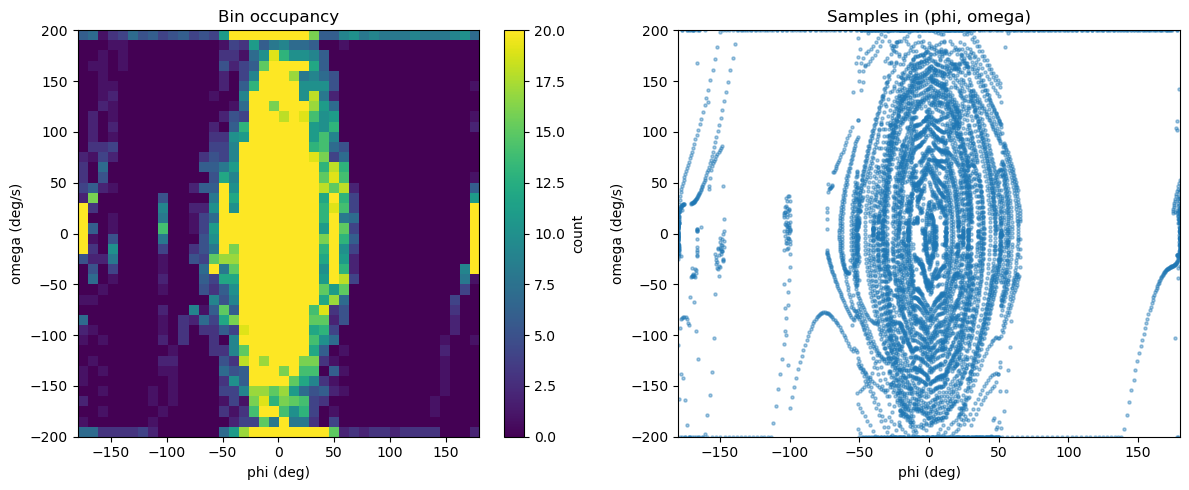

[Cell 3] saved to 'monstertruck_gp_initial_data.npz'


In [25]:
# =========================================================
# Cell 3 — Occupancy-aware data collection (radians)
#   X = [phi, omega_clipped]
#   Y = [dphi, domega]
# =========================================================

import time, math
import numpy as np
import mujoco
import matplotlib.pyplot as plt

TOTAL_CTRL_STEPS = 20000
EPISODE_LEN_MAX  = 3000

OMEGA_CLIP_DEG = 200.0
OMEGA_CLIP_RAD = np.deg2rad(OMEGA_CLIP_DEG)

PRIME_CTRL_STEPS = 300
PRIME_AMPL       = 1.0

MIN_HOLD_CTRL_STEPS = 1
PRINT_EVERY         = 1000

N_BINS_PHI          = 40
N_BINS_OMEGA        = 40
MAX_SAMPLES_PER_BIN = 20

PHI_MIN, PHI_MAX         = -math.pi, math.pi
OMEGA_MIN, OMEGA_MAX     = -OMEGA_CLIP_RAD, OMEGA_CLIP_RAD
occupancy = np.zeros((N_BINS_PHI, N_BINS_OMEGA), dtype=np.int32)


def state_to_bin(phi, omega_clipped):
    phi_c = float(np.clip(phi, PHI_MIN, PHI_MAX))
    om_c  = float(np.clip(omega_clipped, OMEGA_MIN, OMEGA_MAX))

    phi_norm = (phi_c - PHI_MIN) / (PHI_MAX - PHI_MIN + 1e-8)
    om_norm  = (om_c  - OMEGA_MIN) / (OMEGA_MAX - OMEGA_MIN + 1e-8)

    i_phi = int(phi_norm * N_BINS_PHI)
    i_om  = int(om_norm  * N_BINS_OMEGA)

    i_phi = max(0, min(N_BINS_PHI   - 1, i_phi))
    i_om  = max(0, min(N_BINS_OMEGA - 1, i_om))
    return i_phi, i_om


model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)

dt_ctrl      = model.opt.timestep * FRAME_SKIP
flip_tracker = make_flip_tracker(model, frame_skip=FRAME_SKIP)

acc_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "imu_acc")
acc_adr = model.sensor_adr[acc_id] if acc_id >= 0 else None

chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if chassis_id == -1:
    chassis_id = 0
throttle_ids = find_throttle_ids(model)

print(f"[Cell 3] actuators: "
      f"{[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
print(f"[Cell 3] dt_ctrl={dt_ctrl:.4f}s, steps={TOTAL_CTRL_STEPS}")
print(f"[Cell 3] bins: {N_BINS_PHI} x {N_BINS_OMEGA}, max {MAX_SAMPLES_PER_BIN} per bin")


def reset_episode():
    reset_state(model, data)
    flip_tracker.reset()

    for _ in range(PRIME_CTRL_STEPS):
        sgn = 1.0 if rng.uniform() < 0.5 else -1.0
        apply_throttle(data, throttle_ids, PRIME_AMPL * sgn)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

    flip_tracker.reset()
    phi0, omega0, _ = flip_tracker.step(data, chassis_id, model=model)
    return float(phi0), float(omega0)


phi_list       = []
omega_list     = []
u_list         = []
dphi_list      = []
domega_list    = []
acc_pitch_list = []

u_min = +np.inf
u_max = -np.inf

phi_prev, omega_prev = reset_episode()

saved_samples   = 0
episode_step    = 0
ctrl_steps_done = 0
start_wall      = time.perf_counter()

u_curr            = 0.0
hold_steps_left_u = 0

mode = "swing"
burst_steps_left = 0
BURST_PROB       = 0.02
BURST_MIN        = 40
BURST_MAX        = 120

print("[Cell 3] collecting random data...")

while ctrl_steps_done < TOTAL_CTRL_STEPS:
    if episode_step >= EPISODE_LEN_MAX:
        phi_prev, omega_prev = reset_episode()
        episode_step       = 0
        u_curr             = 0.0
        hold_steps_left_u  = 0
        mode               = "swing"
        burst_steps_left   = 0

    if mode == "swing":
        if hold_steps_left_u <= 0:
            u_curr = swing_cont_policy(
                phi_prev,
                omega_prev,
                k=3.0,
                bias=0.8,
                noise_std=0.6,
            )
            hold_steps_left_u = MIN_HOLD_CTRL_STEPS
        hold_steps_left_u -= 1

        if rng.uniform() < BURST_PROB:
            mode = "burst"
            burst_steps_left = int(rng.integers(BURST_MIN, BURST_MAX + 1))
            u_curr = float(rng.choice([-1.0, 1.0]))
    else:  # burst
        burst_steps_left -= 1
        if burst_steps_left <= 0:
            mode = "swing"

    u_min = min(u_min, u_curr)
    u_max = max(u_max, u_curr)

    apply_throttle(data, throttle_ids, u_curr)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    ctrl_steps_done += 1

    phi_curr, omega_curr, _ = flip_tracker.step(data, chassis_id, model=model)

    dphi   = angdiff_rad(phi_curr, phi_prev)
    domega = omega_curr - omega_prev

    if acc_adr is not None:
        acc_vec   = data.sensordata[acc_adr : acc_adr + 3]
        acc_pitch = float(acc_vec[0])
    else:
        acc_pitch = 0.0

    omega_clipped = float(np.clip(omega_prev, -OMEGA_CLIP_RAD, OMEGA_CLIP_RAD))

    i_phi, i_om = state_to_bin(phi_prev, omega_clipped)
    bin_count = occupancy[i_phi, i_om]

    if bin_count < MAX_SAMPLES_PER_BIN:
        occupancy[i_phi, i_om] += 1

        phi_list.append(float(phi_prev))
        omega_list.append(float(omega_clipped))
        u_list.append(float(u_curr))
        dphi_list.append(float(dphi))
        domega_list.append(float(domega))
        acc_pitch_list.append(float(acc_pitch))

        saved_samples += 1

        if saved_samples % PRINT_EVERY == 0:
            elapsed = time.perf_counter() - start_wall
            phi_arr_tmp   = np.asarray(phi_list,   dtype=np.float32)
            omega_arr_tmp = np.asarray(omega_list, dtype=np.float32)
            uniq_bins     = np.count_nonzero(occupancy)
            print(
                f"[Cell 3] saved={saved_samples}  "
                f"(ctrl={ctrl_steps_done}/{TOTAL_CTRL_STEPS})  |  "
                f"phi≈[{phi_arr_tmp.min():+.2f}, {phi_arr_tmp.max():+.2f}] rad  |  "
                f"omega≈[{omega_arr_tmp.min():+.2f}, {omega_arr_tmp.max():+.2f}] rad/s  |  "
                f"u≈[{u_min:+.2f}, {u_max:+.2f}]  |  "
                f"bins={uniq_bins}  |  t={elapsed:.1f}s"
            )

    phi_prev, omega_prev = phi_curr, omega_curr
    episode_step += 1

print("[Cell 3] done.")
print(f"[Cell 3] ctrl steps: {ctrl_steps_done}, saved: {saved_samples}")

phi_arr       = np.asarray(phi_list,       dtype=np.float32)
omega_arr     = np.asarray(omega_list,     dtype=np.float32)
u_arr         = np.asarray(u_list,         dtype=np.float32)
dphi_arr      = np.asarray(dphi_list,      dtype=np.float32)
domega_arr    = np.asarray(domega_list,    dtype=np.float32)
acc_pitch_arr = np.asarray(acc_pitch_list, dtype=np.float32)

if acc_pitch_arr.size > 0:
    acc_pitch_filt_arr = lowpass_offline(
        acc_pitch_arr, dt_ctrl, cutoff_hz=5.0, order=2
    ).astype(np.float32)
else:
    acc_pitch_filt_arr = np.zeros_like(acc_pitch_arr, dtype=np.float32)

X = np.stack([phi_arr, omega_arr], axis=1)
Y = np.stack([dphi_arr, domega_arr], axis=1)

print(f"[Cell 3] X shape={X.shape}, Y shape={Y.shape}")
print(f"[Cell 3] phi≈[{phi_arr.min():+.3f}, {phi_arr.max():+.3f}] rad")
print(f"[Cell 3] omega≈[{omega_arr.min():+.3f}, {omega_arr.max():+.3f}] rad/s")
print(f"[Cell 3] u≈[{u_min:+.3f}, {u_max:+.3f}]")
print(f"[Cell 3] occupied bins={np.count_nonzero(occupancy)} / {N_BINS_PHI * N_BINS_OMEGA}")
if acc_pitch_arr.size > 0:
    print(f"[Cell 3] acc (raw)≈[{acc_pitch_arr.min():+.3f}, {acc_pitch_arr.max():+.3f}]")
    print(f"[Cell 3] acc (filt)≈[{acc_pitch_filt_arr.min():+.3f}, {acc_pitch_filt_arr.max():+.3f}]")


phi_deg   = np.rad2deg(phi_arr)
omega_deg = np.rad2deg(omega_arr)

PHI_MIN_DEG, PHI_MAX_DEG       = -180.0, 180.0
OMEGA_MIN_DEG, OMEGA_MAX_DEG   = -OMEGA_CLIP_DEG, OMEGA_CLIP_DEG

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax0 = axes[0]
im = ax0.imshow(
    occupancy.T,
    origin="lower",
    aspect="auto",
    extent=[PHI_MIN_DEG, PHI_MAX_DEG, OMEGA_MIN_DEG, OMEGA_MAX_DEG],
)
ax0.set_xlabel("phi (deg)")
ax0.set_ylabel("omega (deg/s)")
ax0.set_title("Bin occupancy")
fig.colorbar(im, ax=ax0, label="count")

ax1 = axes[1]
ax1.scatter(phi_deg, omega_deg, s=5, alpha=0.4)
ax1.set_xlabel("phi (deg)")
ax1.set_ylabel("omega (deg/s)")
ax1.set_title("Samples in (phi, omega)")
ax1.set_xlim(PHI_MIN_DEG, PHI_MAX_DEG)
ax1.set_ylim(OMEGA_MIN_DEG, OMEGA_MAX_DEG)

fig.tight_layout()
plt.show()

np.savez_compressed(
    "monstertruck_gp_initial_data.npz",
    X=X, Y=Y,
    phi=phi_arr, omega=omega_arr, u=u_arr,
    dphi=dphi_arr, domega=domega_arr,
    acc_pitch=acc_pitch_arr,
    acc_pitch_filt=acc_pitch_filt_arr,
    dt_ctrl=dt_ctrl,
    u_min=u_min, u_max=u_max,
    omega_clip_deg=OMEGA_CLIP_DEG,
)
print("[Cell 3] saved to 'monstertruck_gp_initial_data.npz'")


Visulisation of collected data

In [ ]:
# ============================================================
# Cell 5 — GP dynamics model: (phi, omega) -> (omega, alpha)
# ============================================================
import math
import numpy as np
import torch
import gpytorch

MAX_CG_ITERS = 2000

# ---------------- Data ----------------
data = np.load("monstertruck_gp_initial_data.npz")
X_np = data["X"].astype(np.float32)         # (N, 2): [phi, omega_clipped]
N, Dx = X_np.shape

use_sensor_targets = False

if "omega" in data:
    omega_arr = data["omega"].astype(np.float32)

    if "acc_pitch_filt" in data:
        acc_signal = data["acc_pitch_filt"].astype(np.float32)
        print("[Cell 5] Using acc_pitch_filt for alpha.")
        use_sensor_targets = True
    elif "acc_pitch" in data:
        acc_signal = data["acc_pitch"].astype(np.float32)
        print("[Cell 5] Using acc_pitch for alpha.")
        use_sensor_targets = True
    else:
        acc_signal = None
        print("[Cell 5] No accel signal; cannot form alpha.")
else:
    omega_arr = None
    acc_signal = None
    print("[Cell 5] 'omega' not found; using stored Y.")

if use_sensor_targets and (acc_signal is not None):
    print("[Cell 5] Targets from sensors: Y = [omega, alpha].")
    y0 = omega_arr
    y1 = acc_signal
    Y_np = np.stack([y0, y1], axis=1).astype(np.float32)
else:
    print("[Cell 5] Targets from file: Δphi, Δomega.")
    Y_np = data["Y"].astype(np.float32)

_, Dy = Y_np.shape
assert Dx == 2 and Dy == 2, f"Unexpected shapes: X={X_np.shape}, Y={Y_np.shape}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Cell 5] Device: {device}")


# ---------------- Standardizer ----------------
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, x: np.ndarray):
        self.mean = x.mean(axis=0, keepdims=True).astype(np.float32)
        self.std  = x.std(axis=0, keepdims=True).astype(np.float32)
        self.std[self.std < 1e-8] = 1.0

    def transform(self, x: np.ndarray) -> np.ndarray:
        return (x - self.mean) / self.std

    def inverse_transform(self, x: np.ndarray) -> np.ndarray:
        return x * self.std + self.mean


# ---------------- Exact GP ----------------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ---------------- GP manager ----------------
class GPManager:
    def __init__(
        self,
        kernel='RBF',
        lr=0.05,
        iters_init=800,
        iters_retrain=200,
        max_points=None,
        seed: int = 0,
    ):
        self.kernel = kernel
        self.lr = lr
        self.iters_init = iters_init
        self.iters_retrain = iters_retrain
        self.max_points = max_points

        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        self.model = None
        self.likelihood = None

        self.X_all = None
        self.Y_all = None

        self._rng = np.random.default_rng(seed)

    def _train_gp(self, train_x_t, train_y_t, iters, warm_start):
        if (self.model is None) or (self.likelihood is None) or (not warm_start):
            self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
            self.model = ExactGPModel(
                train_x_t,
                train_y_t,
                self.likelihood,
                kernel=self.kernel,
                ard_dims=train_x_t.shape[-1],
            ).to(device)
        else:
            self.model.set_train_data(inputs=train_x_t, targets=train_y_t, strict=False)

        self.model.train()
        self.likelihood.train()

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        mode_str = "warm" if warm_start else "fresh"
        n_train = train_x_t.shape[0]
        print(f"[GP] train on {n_train} pts | {mode_str} | iters={iters}")

        log_every = max(1, iters // 8)

        with gpytorch.settings.max_cg_iterations(MAX_CG_ITERS):
            for i in range(iters):
                opt.zero_grad()
                out = self.model(train_x_t)
                loss = -mll(out, train_y_t)
                loss.backward()
                opt.step()

                if (i == 0) or (i == iters - 1) or ((i + 1) % log_every == 0):
                    print(f"  iter {i+1:4d}/{iters}  loss={loss.item():.4f}")

        print("[GP] done.")

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        self.X_all = X.copy()
        self.Y_all = y.copy()

        self.x_scaler.fit(X)
        self.y_scaler.fit(y)

        Xn = self.x_scaler.transform(X)
        yn = self.y_scaler.transform(y).ravel()

        tx = torch.from_numpy(Xn).to(device)
        ty = torch.from_numpy(yn).to(device)

        self._train_gp(tx, ty, iters=self.iters_init, warm_start=False)

    def append_and_fit(self, X_new: np.ndarray, y_new: np.ndarray):
        X_new = np.asarray(X_new, dtype=np.float32)
        y_new = np.asarray(y_new, dtype=np.float32).reshape(-1, 1)

        if self.X_all is None:
            X_cat = X_new
            Y_cat = y_new
        else:
            X_cat = np.concatenate([self.X_all, X_new], axis=0)
            Y_cat = np.concatenate([self.Y_all, y_new], axis=0)

        if (self.max_points is not None) and (X_cat.shape[0] > self.max_points):
            X_cat = X_cat[-self.max_points:]
            Y_cat = Y_cat[-self.max_points:]

        self.X_all = X_cat
        self.Y_all = Y_cat

        print(f"[GP] retrain buffer = {X_cat.shape[0]} (added {X_new.shape[0]}).")

        self.x_scaler.fit(X_cat)
        self.y_scaler.fit(Y_cat)

        Xn = self.x_scaler.transform(X_cat)
        yn = self.y_scaler.transform(Y_cat).ravel()

        tx = torch.from_numpy(Xn).to(device)
        ty = torch.from_numpy(yn).to(device)

        warm = self.model is not None
        self._train_gp(tx, ty, iters=self.iters_retrain, warm_start=warm)

    @torch.no_grad()
    def predict(self, X_query: np.ndarray):
        assert self.model is not None, "GP not trained yet."

        self.model.eval()
        self.likelihood.eval()

        Xq = np.asarray(X_query, dtype=np.float32)
        Xq_n = self.x_scaler.transform(Xq)
        tx = torch.from_numpy(Xq_n).to(device)

        with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(MAX_CG_ITERS):
            pred = self.likelihood(self.model(tx))

        mean_n = pred.mean.detach().cpu().numpy()
        var_n  = pred.variance.detach().cpu().numpy()

        mean = self.y_scaler.inverse_transform(mean_n.reshape(-1, 1)).ravel()
        y_std = float(self.y_scaler.std.ravel()[0])
        var = (y_std ** 2) * var_n
        return mean.astype(np.float32), var.astype(np.float32)


# ---------------- Train GPs: omega, alpha ----------------
gps = [
    GPManager(kernel='RBF', lr=0.05, iters_init=600, iters_retrain=200, max_points=None, seed=0),  # omega
    GPManager(kernel='RBF', lr=0.05, iters_init=600, iters_retrain=200, max_points=None, seed=1),  # alpha
]

print(f"[Cell 5] Initial training on N = {N} samples...")
gps[0].fit(X_np, Y_np[:, 0])   # omega
gps[1].fit(X_np, Y_np[:, 1])   # alpha
print("[Cell 5] Trained GP models for (omega, alpha).")


# ---------------- Public wrapper ----------------
def gp_predict_deriv_numpy(X_query: np.ndarray):
    """
    X_query: (N, 2) = [phi, omega_clipped]
    returns:
      omega_mean, omega_var, alpha_mean, alpha_var
    """
    omega_mean, omega_var = gps[0].predict(X_query)
    alpha_mean, alpha_var = gps[1].predict(X_query)
    return omega_mean, omega_var, alpha_mean, alpha_var


# ---------------- Meta info ----------------
try:
    dt_ctrl_meta = float(data.get("dt_ctrl", 0.01))
except Exception:
    dt_ctrl_meta = 0.01

if 'OMEGA_CLIP_RAD' in globals():
    omega_clip_meta = float(OMEGA_CLIP_RAD)
else:
    try:
        omega_clip_meta = float(np.deg2rad(data.get("omega_clip_deg", 200.0)))
    except Exception:
        omega_clip_meta = float(math.radians(200.0))

gp_data_meta = dict(
    dt_ctrl=float(dt_ctrl_meta),
    omega_clip_rad=float(omega_clip_meta),
    N_train=int(N),
)

print("[Cell 5] gp_predict_deriv_numpy and gp_data_meta ready.")


[Cell 5] Using acc_pitch_filt for alpha.
[Cell 5] Targets from sensors: Y = [omega, alpha].
[Cell 5] Device: cuda
[Cell 5] Initial training on N = 8307 samples...
[GP] train on 8307 pts | fresh | iters=600
  iter    1/600  loss=0.7505
  iter   75/600  loss=-1.0198
  iter  150/600  loss=nan


C:\Users\wts28\miniconda3\envs\RL\Lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 2000 iterations with average residual norm 14.095008850097656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
C:\Users\wts28\miniconda3\envs\RL\Lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 2000 iterations with average residual norm 266273.625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
C:\Users\wts28\miniconda3\envs\RL\Lib\site-packages\linear_operator\utils\linear_cg.py:338

  iter  225/600  loss=-3.2104


C:\Users\wts28\miniconda3\envs\RL\Lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 2000 iterations with average residual norm 2.09600830078125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [ ]:
# ============================================================
# Cell 5 — GP dynamics model for MonsterTruck (sensor-based derivatives)
#   - Models: (phi, omega_clipped) -> (omega, alpha)
#   - X = [phi, omega_clipped]
#   - Y (sensor-based):
#       y0 = omega_t   (pitch rate = d(phi)/dt, from gyro)
#       y1 = alpha_t   (pitch acceleration = d(omega)/dt, from accel)
#   - Fallback: use stored Y (finite-difference Δphi, Δomega) from file
#   - Two separate ExactGPs (one per output dim)
#   - Normalization of X, Y
#   - Numpy wrapper: gp_predict_deriv_numpy(X_query)
#   - Supports incremental retraining via append_and_fit(...)
# ============================================================
import math
import numpy as np
import torch
import gpytorch

# ---------- Load data and build X, Y ----------

data = np.load("monstertruck_gp_initial_data.npz")
X_np = data["X"].astype(np.float32)  # (N, 2): [phi, omega_clipped]
N, Dx = X_np.shape

use_sensor_targets = False

# We need omega (gyro-based) and ideally accel (filtered or raw)
if "omega" in data:
    omega_arr = data["omega"].astype(np.float32)   # (N,) clipped ω from FlipTracker/IMU gyro

    # Prefer filtered accel if available, else raw accel
    if "acc_pitch_filt" in data:
        acc_signal = data["acc_pitch_filt"].astype(np.float32)
        print("[Cell 5] Using filtered accel 'acc_pitch_filt' for alpha (pitch acceleration).")
        use_sensor_targets = True
    elif "acc_pitch" in data:
        acc_signal = data["acc_pitch"].astype(np.float32)
        print("[Cell 5] Using raw 'acc_pitch' for alpha (no filtered version found).")
        use_sensor_targets = True
    else:
        acc_signal = None
        print("[Cell 5] No accel signal found; cannot form alpha.")
else:
    omega_arr = None
    acc_signal = None
    print("[Cell 5] 'omega' not found; will fall back to stored Y.")

if use_sensor_targets and (acc_signal is not None):
    # Sensor-based derivatives:
    #   y0 = omega_t   (pitch rate)
    #   y1 = alpha_t   (pitch acceleration)
    print("[Cell 5] Using sensor-based derivatives: Y = [omega, alpha].")
    y0 = omega_arr
    y1 = acc_signal
    Y_np = np.stack([y0, y1], axis=1).astype(np.float32)
else:
    # Fallback: use stored Y (old scheme: finite-difference Δphi, Δomega)
    print("[Cell 5] Using Y from file (finite-difference Δphi, Δomega).")
    Y_np = data["Y"].astype(np.float32)

_, Dy = Y_np.shape
assert Dx == 2 and Dy == 2, f"Unexpected shapes: X={X_np.shape}, Y={Y_np.shape}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Cell 5] Using device: {device}")


# ---------- Simple standardizer ----------
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, x: np.ndarray):
        self.mean = x.mean(axis=0, keepdims=True).astype(np.float32)
        self.std  = x.std(axis=0, keepdims=True).astype(np.float32)
        # Avoid division by zero
        self.std[self.std < 1e-8] = 1.0

    def transform(self, x: np.ndarray) -> np.ndarray:
        return (x - self.mean) / self.std

    def inverse_transform(self, x: np.ndarray) -> np.ndarray:
        return x * self.std + self.mean


# ---------- Exact GP model (single-output) ----------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
            self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
        else:
            # Default to Matern if not RBF
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
            )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ---------- GP manager for one output dimension ----------
class GPManager:
    def __init__(
        self,
        kernel='RBF',
        lr=0.05,
        iters_init=800,      # initial training iters
        iters_retrain=200,   # retrain iters
        max_points=None,     # if not None: keep only most recent max_points
        seed: int = 0,
    ):
        self.kernel = kernel
        self.lr = lr
        self.iters_init = iters_init
        self.iters_retrain = iters_retrain
        self.max_points = max_points

        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        self.model = None
        self.likelihood = None

        # Full dataset (for logging / viz / live plots)
        self.X_all = None
        self.Y_all = None

        self._rng = np.random.default_rng(seed)

    # ---- internal train helper (supports warm-start) ----
    def _train_gp(
        self,
        train_x_t: torch.Tensor,
        train_y_t: torch.Tensor,
        iters: int,
        warm_start: bool,
    ):
        """
        train_x_t, train_y_t: tensors on correct device
        warm_start:
          - False: create new model + likelihood
          - True : reuse existing model hyper-params via set_train_data
        """
        if (self.model is None) or (self.likelihood is None) or (not warm_start):
            # Fresh model
            self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
            self.model = ExactGPModel(
                train_x_t,
                train_y_t,
                self.likelihood,
                kernel=self.kernel,
                ard_dims=train_x_t.shape[-1],
            ).to(device)
        else:
            # Reuse hyperparams; only update train data
            self.model.set_train_data(inputs=train_x_t, targets=train_y_t, strict=False)

        self.model.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        mode_str = "warm" if warm_start else "fresh"
        n_train = train_x_t.shape[0]
        print(f"[GPManager] Training GP ({self.kernel}) on {n_train} pts | {mode_str} start | iters={iters}")

        # Print about ~8 times max, but always at first and last
        log_every = max(1, iters // 8)

        for i in range(iters):
            optimizer.zero_grad()
            output = self.model(train_x_t)
            loss = -mll(output, train_y_t)
            loss.backward()
            optimizer.step()

            if (i == 0) or (i == iters - 1) or ((i + 1) % log_every == 0):
                print(f"  [GP] iter {i+1:4d}/{iters} | loss = {loss.item():.4f}")

        print("[GPManager] Training done.")

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Initial training on given X, y (numpy arrays).
        Uses ALL provided points (already bin-thinned from Cell 3).
        """
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        # Store full dataset
        self.X_all = X.copy()
        self.Y_all = y.copy()

        # Fit scalers and normalize
        self.x_scaler.fit(X)
        self.y_scaler.fit(y)

        Xn = self.x_scaler.transform(X)
        yn = self.y_scaler.transform(y).ravel()  # 1D target

        train_x = torch.from_numpy(Xn).to(device)
        train_y = torch.from_numpy(yn).to(device)

        self._train_gp(train_x, train_y, iters=self.iters_init, warm_start=False)

    def append_and_fit(self, X_new: np.ndarray, y_new: np.ndarray):
        """
        Append new (X_new, y_new) to existing dataset and retrain with warm-start.
        If max_points is not None, keep only the most recent max_points samples.
        """
        X_new = np.asarray(X_new, dtype=np.float32)
        y_new = np.asarray(y_new, dtype=np.float32).reshape(-1, 1)

        if self.X_all is None:
            X_cat = X_new
            Y_cat = y_new
        else:
            X_cat = np.concatenate([self.X_all, X_new], axis=0)
            Y_cat = np.concatenate([self.Y_all, y_new], axis=0)

        # Optional cap on GP buffer (keep most recent samples)
        if (self.max_points is not None) and (X_cat.shape[0] > self.max_points):
            X_cat = X_cat[-self.max_points:]
            Y_cat = Y_cat[-self.max_points:]

        self.X_all = X_cat
        self.Y_all = Y_cat

        print(f"[GPManager] Retrain buffer size = {X_cat.shape[0]} (new added = {X_new.shape[0]}).")

        # Refit scalers and normalize
        self.x_scaler.fit(X_cat)
        self.y_scaler.fit(Y_cat)

        Xn = self.x_scaler.transform(X_cat)
        yn = self.y_scaler.transform(Y_cat).ravel()

        train_x = torch.from_numpy(Xn).to(device)
        train_y = torch.from_numpy(yn).to(device)

        warm = (self.model is not None)
        self._train_gp(train_x, train_y, iters=self.iters_retrain, warm_start=warm)

    @torch.no_grad()
    def predict(self, X_query: np.ndarray):
        """
        Predict mean and variance for X_query (numpy).
        Returns: mean (N,), var (N,)
        """
        assert self.model is not None, "GP not trained yet."

        self.model.eval()
        self.likelihood.eval()

        Xq = np.asarray(X_query, dtype=np.float32)
        Xq_n = self.x_scaler.transform(Xq)
        x_t = torch.from_numpy(Xq_n).to(device)

        with gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(x_t))

        mean_n = pred.mean.detach().cpu().numpy()
        var_n  = pred.variance.detach().cpu().numpy()

        # Un-normalize mean; adjust variance for scaling
        mean = self.y_scaler.inverse_transform(mean_n.reshape(-1, 1)).ravel()
        # If y = s * y_n + m, then Var[y] = s^2 * Var[y_n]
        y_std = float(self.y_scaler.std.ravel()[0])
        var   = (y_std ** 2) * var_n
        return mean.astype(np.float32), var.astype(np.float32)


# ---------- Train two GPs: for omega and alpha ----------
gps = [
    GPManager(kernel='RBF', lr=0.05, iters_init=600, iters_retrain=200, max_points=None, seed=0),  # omega
    GPManager(kernel='RBF', lr=0.05, iters_init=600, iters_retrain=200, max_points=None, seed=1),  # alpha
]

print(f"[Cell 5] Initial training on N = {N} samples...")

# GP for omega (pitch rate)
gps[0].fit(X_np, Y_np[:, 0])
# GP for alpha (pitch acceleration)
gps[1].fit(X_np, Y_np[:, 1])

print("[Cell 5] Trained two GP models for (omega, alpha).")


# ---------- Numpy wrapper: single-step derivatives ----------
def gp_predict_deriv_numpy(X_query: np.ndarray):
    """
    Given X_query (N, 2) = [phi, omega_clipped],
    return:
        omega_mean (N,), omega_var (N,),
        alpha_mean (N,), alpha_var (N,),

    where:
        omega ≈ d(phi)/dt
        alpha ≈ d(omega)/dt

    All numpy float32 arrays.
    """
    omega_mean, omega_var = gps[0].predict(X_query)
    alpha_mean, alpha_var = gps[1].predict(X_query)
    return omega_mean, omega_var, alpha_mean, alpha_var


# ---------- Meta info for integrator / MPPI ----------
try:
    dt_ctrl_meta = float(data.get("dt_ctrl", 0.01))
except Exception:
    dt_ctrl_meta = 0.01

if 'OMEGA_CLIP_RAD' in globals():
    omega_clip_meta = float(OMEGA_CLIP_RAD)
else:
    try:
        omega_clip_meta = float(np.deg2rad(data.get("omega_clip_deg", 200.0)))
    except Exception:
        omega_clip_meta = float(math.radians(200.0))

gp_data_meta = dict(
    dt_ctrl=float(dt_ctrl_meta),
    omega_clip_rad=float(omega_clip_meta),
    N_train=int(N),
)

print("[Cell 5] gp_predict_deriv_numpy(...) and gp_data_meta ready.")


[Cell 6] Visualizing GP[1] with 1415 training points.


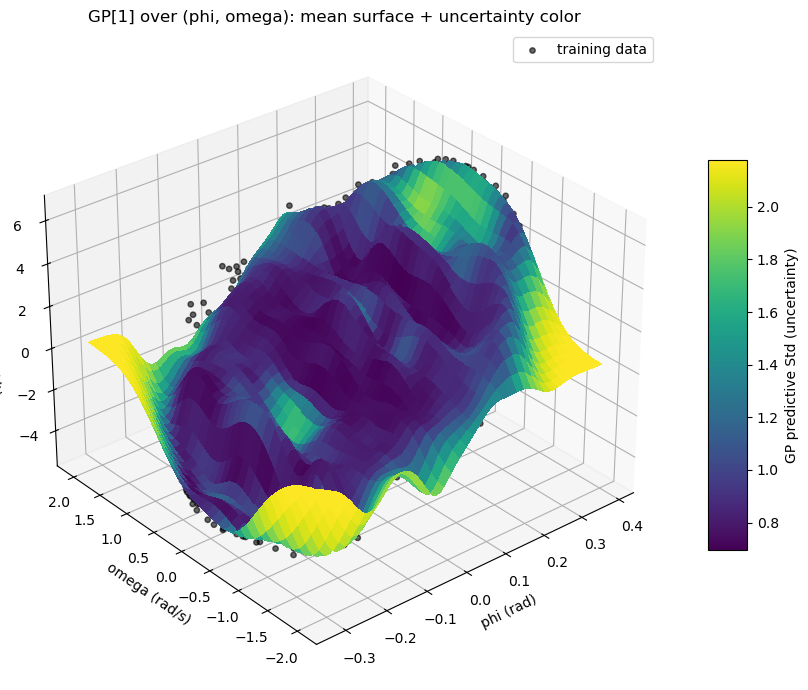

In [12]:
# ============================================================
# Cell 5.5 — GP visualization over (phi, omega)
#   - Visualize GP mean + uncertainty for one output
#   - Uses X_all, Y_all stored in GPManager
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Choose which GP to visualize
#   gps[0] → omega (pitch rate)
#   gps[1] → alpha (pitch acceleration)
# --------------------------------------------------------
gp_index = 1          # 0 for omega, 1 for alpha
gp = gps[gp_index]

label_z = "omega (dphi/dt)" if gp_index == 0 else "alpha (domega/dt)"

# --------------------------------------------------------
# Get training data (state → derivative)
#   X_all: [phi, omega]
#   Y_all: [omega] or [alpha] depending on gp_index
# --------------------------------------------------------
X_train = gp.X_all
Y_train = gp.Y_all.reshape(-1)

phi_train   = X_train[:, 0]
omega_train = X_train[:, 1]
target      = Y_train

print(f"[Cell 6] Visualizing GP[{gp_index}] with {X_train.shape[0]} training points.")

# --------------------------------------------------------
# Define grid over (phi, omega)
# --------------------------------------------------------
phi_min, phi_max     = phi_train.min(),   phi_train.max()
omega_min, omega_max = omega_train.min(), omega_train.max()

# (you can shrink the range a bit if needed)
n_grid = 80
phi_grid   = np.linspace(phi_min,   phi_max,   n_grid)
omega_grid = np.linspace(omega_min, omega_max, n_grid)
P, W = np.meshgrid(phi_grid, omega_grid)

# Query points for the GP: X_grid = [phi, omega]
X_grid = np.column_stack([P.ravel(), W.ravel()])

# --------------------------------------------------------
# GP predictions on the grid
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)    # Mean, Var shape: (Ngrid,)
Mean = Mean.reshape(P.shape)
Std  = np.sqrt(Var.reshape(P.shape))

# --------------------------------------------------------
# Normalize Std for color mapping (uncertainty)
# --------------------------------------------------------
norm   = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, W, Mean,
    facecolors=colors,
    linewidth=0,
    antialiased=False,
    shade=False
)

# Colorbar for predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP predictive Std (uncertainty)')

# --------------------------------------------------------
# Overlay training data in (phi, omega, target)
# --------------------------------------------------------
ax.scatter(
    phi_train, omega_train, target,
    color='k', s=15, alpha=0.6,
    label='training data'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('phi (rad)')
ax.set_ylabel('omega (rad/s)')
ax.set_zlabel(label_z)
ax.set_title(f"GP[{gp_index}] over (phi, omega): mean surface + uncertainty color")

ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


[Cell 6] Using gp.X_all[:, 0] to set φ slice range.
[Cell 6] φ data range ≈ [-18.28, +22.22]°, span ≈ 40.50°


ValueError: 'taborange' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

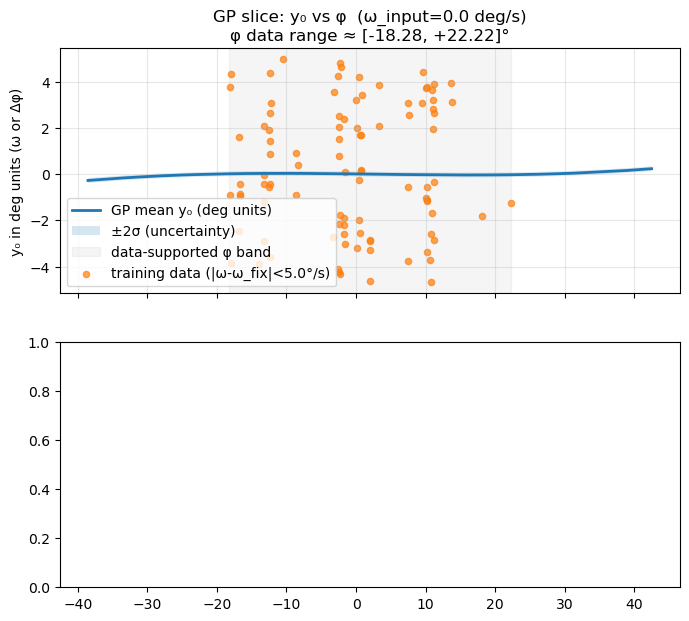

In [15]:
# ============================================================
# Cell 6 — GP slice (y0) + data distribution over φ
#   - Plot 1: GP mean ± 2σ vs φ at fixed ω_input, but only over
#             the φ range actually covered by data (± margin)
#   - Plot 2: Histogram of collected φ over [-180°, 180°]
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: first output model (y0)
#   With sensor-based targets (Cell 5), this is:
#       y0 ≈ omega_t (pitch rate, rad/s)
#   With fallback targets, it is:
#       y0 ≈ Δφ per step (rad)
# --------------------------------------------------------
gp = gps[0]        # GP for y0 (omega or Δφ)

# Fix angular rate for the slice (input ω to the GP)
omega_fixed = 0.0      # rad/s (≈ 0 deg/s)

# --------------------------------------------------------
# Determine φ range from data (so we don't extrapolate to ±180°)
# --------------------------------------------------------
if gp.X_all is not None:
    phi_all_for_range = gp.X_all[:, 0].astype(np.float32)  # radians
    print("[Cell 6] Using gp.X_all[:, 0] to set φ slice range.")
elif 'phi_arr' in globals():
    phi_all_for_range = phi_arr.astype(np.float32)
    print("[Cell 6] Using phi_arr to set φ slice range.")
else:
    data_npz = np.load("monstertruck_gp_initial_data.npz")
    phi_all_for_range = data_npz["phi"].astype(np.float32)
    print("[Cell 6] Using phi from file to set φ slice range.")

phi_deg_all_range = np.rad2deg(phi_all_for_range)
phi_min_data_deg = float(phi_deg_all_range.min())
phi_max_data_deg = float(phi_deg_all_range.max())

# Add a small margin (e.g. ±5°)
margin_deg = 5.0
phi_min_plot_deg = phi_min_data_deg - margin_deg
phi_max_plot_deg = phi_max_data_deg + margin_deg

phi_grid_deg = np.linspace(phi_min_plot_deg, phi_max_plot_deg, 400, dtype=np.float32)
phi_grid = np.deg2rad(phi_grid_deg)

# Construct query points [φ, ω_fixed]
X_query = np.column_stack([
    phi_grid,
    np.full_like(phi_grid, omega_fixed, dtype=np.float32),
])

# --------------------------------------------------------
# Predict GP mean and std (in radians units)
# --------------------------------------------------------
Mean_rad, Var = gp.predict(X_query)
Var = np.maximum(Var, 0.0)        # numerical safety
Std_rad = np.sqrt(Var)

# Convert to degrees for plotting
Mean_deg = np.rad2deg(Mean_rad)   # deg/s or deg/step
Std_deg  = np.rad2deg(Std_rad)

# --------------------------------------------------------
# Overlay training data near the chosen ω slice
# --------------------------------------------------------
X_all = gp.X_all         # shape (N, 2): [φ, ω_clipped]
Y_all = gp.Y_all         # shape (N, 1): y0 (omega or Δφ)

if X_all is None or Y_all is None:
    print("[Cell 6] No training data stored in gp.X_all / gp.Y_all.")
    phi_train_deg  = np.array([])
    y0_train_deg   = np.array([])
else:
    Y_all_rad = Y_all.ravel()

    # Select points close to the chosen slice in ω
    omega_tol_deg = 5.0          # +/- 5 deg/s around omega_fixed

    mask = (
        np.abs(np.rad2deg(X_all[:, 1] - omega_fixed)) < omega_tol_deg
    )

    phi_train_deg = np.rad2deg(X_all[mask, 0])
    y0_train_deg  = np.rad2deg(Y_all_rad[mask])

# --------------------------------------------------------
# Plot 1: GP mean ± 2σ as shaded region (within data φ-range)
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(phi_grid_deg, Mean_deg, lw=2, label='GP mean y₀ (deg units)')

plt.fill_between(
    phi_grid_deg,
    Mean_deg - 2 * Std_deg,
    Mean_deg + 2 * Std_deg,
    alpha=0.2,
    label='±2σ (uncertainty)'
)

# Overlay training data
if phi_train_deg.size > 0:
    plt.scatter(
        phi_train_deg,
        y0_train_deg,
        s=25,
        alpha=0.7,
        label=f'training data (|ω-ω_fix|<{omega_tol_deg}°/s)'
    )
else:
    print("[Cell 6] No training points matched the ω slice mask.")

plt.xlabel("flip angle φ (deg)  —  0 = upside-down, ±180 = upright")
plt.ylabel("y₀ in deg units (ω or Δφ)")
plt.title(
    f"GP slice: y₀ vs φ  (ω_input={np.rad2deg(omega_fixed):.1f} deg/s)\n"
    f"φ data range ≈ [{phi_min_data_deg:+.2f}, {phi_max_data_deg:+.2f}]°"
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2 — Data distribution over flip angle φ (deg)
# ============================================================

# Get φ for histogram (same logic as before)
if gp.X_all is not None:
    phi_all = gp.X_all[:, 0].astype(np.float32)   # radians
    print("[Cell 6] Using gp.X_all[:, 0] for φ distribution.")
elif 'phi_arr' in globals():
    phi_all = phi_arr.astype(np.float32)
    print("[Cell 6] Using phi_arr from collection for φ distribution.")
elif 'X_np' in globals():
    phi_all = X_np[:, 0].astype(np.float32)
    print("[Cell 6] Using X_np[:, 0] for φ distribution.")
else:
    data_npz = np.load("monstertruck_gp_initial_data.npz")
    phi_all = data_npz["phi"].astype(np.float32)
    print("[Cell 6] Loaded phi from 'monstertruck_gp_initial_data.npz' for distribution.")

phi_deg_all = np.rad2deg(phi_all)
phi_min_all, phi_max_all = phi_deg_all.min(), phi_deg_all.max()
N_hist = phi_deg_all.shape[0]

print(f"[Cell 6] N samples (for histogram) = {N_hist}")
print(f"[Cell 6] φ range (deg) ≈ [{phi_min_all:+.2f}, {phi_max_all:+.2f}]")

# Histogram over [-180, 180]
bins = 72  # 5° bins: 360 / 5 = 72
bin_edges = np.linspace(-180.0, 180.0, bins + 1)

plt.figure(figsize=(8, 4))
plt.hist(phi_deg_all, bins=bin_edges, alpha=0.85, edgecolor='k', linewidth=0.4)

plt.xlabel("flip angle φ (deg)  —  0 = upside-down, ±180 = upright")
plt.ylabel("count")
plt.title("Distribution of collected data over flip angle φ")
plt.xlim([-180, 180])
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


|GP Training Script

In [ ]:
# ============================================================
# Cell 7 — GP-based dynamics + task & exploration costs
#   - GP models: X = [phi, omega_clipped] -> [Δphi, Δomega]
#   - No action input to GP (dynamics depend only on state)
# ============================================================
import numpy as np

# ---------- Helpers ----------
def clip_angle_pi(phi):
    """Wrap any angle to (-pi, pi]."""
    return ((phi + np.pi) % (2.0 * np.pi)) - np.pi


def is_upright_success(phi, omega):
    """
    Success condition in radians, using global thresholds from Cell 1:
      - abs(phi) >= SUCCESS_ENTER_RAD
      - abs(omega) <= MAX_UPRIGHT_RATE_RAD
    """
    return (abs(phi) >= SUCCESS_ENTER_RAD) and (abs(omega) <= MAX_UPRIGHT_RATE_RAD)


# ---------- GP-based single-step dynamics ----------
def gp_step(state, action):
    """
    One-step prediction using the learned GP dynamics.

    Inputs:
      state  : [phi, omega] at time t  (radians, rad/s)
      action : throttle u_t in [-1, 1] (NOT used by the GP; kept for cost terms)

    The GP was trained on:
      X = [phi, omega_clipped]
      Y = [Δphi, Δomega]

    Returns:
      next_state : [phi_next, omega_next]
      var_total  : scalar uncertainty measure = Var(Δphi) + Var(Δomega)
    """
    phi, omega = float(state[0]), float(state[1])

    # Clip omega exactly the same way as in data collection (Cell 3)
    omega_in = float(np.clip(
        omega,
        -gp_data_meta["omega_clip_rad"],
        +gp_data_meta["omega_clip_rad"]
    ))

    # Query GP with [phi, omega_clipped]
    X_query = np.array([[phi, omega_in]], dtype=np.float32)  # shape (1, 2)

    dphi_mean, dphi_var, domega_mean, domega_var = gp_predict_delta_numpy(X_query)

    dphi_m   = float(dphi_mean[0])
    domega_m = float(domega_mean[0])
    v_phi    = float(dphi_var[0])
    v_omega  = float(domega_var[0])

    # Discrete-time update over one control interval dt_ctrl
    phi_next   = clip_angle_pi(phi + dphi_m)
    omega_next = omega + domega_m

    # Aggregate uncertainty for exploration bonus
    var_total = v_phi + v_omega

    next_state = np.array([phi_next, omega_next], dtype=np.float32)
    return next_state, var_total


# ---------- Exploration cost ----------
def explore_cost_step(var_total, eps=1e-8):
    """
    Exploration cost: -log(variance).
    Higher predictive variance -> more negative cost (i.e., better for exploration
    when added with a positive weight).
    """
    v = max(float(var_total), eps)
    return -np.log(v)


# ---------- Task cost weights ----------
TASK_COST_WEIGHTS = dict(
    w_angle=200.0,                    # weight on angle error
    w_rate=20.0,                      # weight on angular rate
    w_jerk=1.0,                       # weight on control change Δu
    w_time=1.5,                       # per-step time penalty
    angle_norm=np.pi,                 # normalize angle error by π
    omega_ref=np.deg2rad(120.0),      # reference rate for scaling
)


def task_cost_step(state, action, w=TASK_COST_WEIGHTS):
    """
    Task cost encouraging:
      - being upright (φ ≈ ±π, away from upside-down φ ≈ 0)
      - reasonable angular rates, especially near upright
      - small control jerk (handled separately in rollout)
    """
    phi, omega = float(state[0]), float(state[1])

    # Angle term: distance from upright (π away from upside-down)
    angle_err = np.pi - min(abs(phi), np.pi)       # 0 when φ at ±π, max at 0
    angle_dist = (angle_err / w["angle_norm"])     # normalized to [0, 1]
    angle_dist = np.clip(angle_dist, 0.0, 1.0)

    c_angle = w["w_angle"] * (angle_dist**2)

    # Rate term: only penalize large |ω| when closer to upright
    closeness = 1.0 - angle_dist                   # 0 near UD, 1 near upright
    omega_norm = omega / w["omega_ref"]
    c_rate = w["w_rate"] * closeness * (omega_norm**2)

    # Time penalty
    c_time = w["w_time"]

    return c_angle + c_rate + c_time


def rollout_cost_from_actions(
    state0,
    actions,
    wt_task=1.0,
    wt_explore=0.0,
    gamma=0.99,
    early_stop_on_success=True
):
    """
    Rollout cost for a candidate action sequence using the GP dynamics.

    Inputs:
      state0    : initial state [phi, omega]
      actions   : sequence of scalar throttles (length H)
      wt_task   : weight on task cost sum
      wt_explore: weight on exploration bonus sum
      gamma     : discount factor
      early_stop_on_success: if True, stop when upright success is reached

    Returns:
      total_cost, J_task, J_expl
    """
    state = np.array(state0, dtype=np.float32)
    H = len(actions)

    J_task = 0.0
    J_expl = 0.0
    disc = 1.0

    u_prev = 0.0

    for t in range(H):
        u_t = float(actions[t])

        # GP prediction for next state (dynamics independent of u_t)
        next_state, var_total = gp_step(state, u_t)

        # Task cost at current state
        c_task_core = task_cost_step(state, u_t)

        # Jerk penalty on control changes
        du = u_t - u_prev
        c_jerk = TASK_COST_WEIGHTS["w_jerk"] * (du**2)

        c_task = c_task_core + c_jerk

        # Exploration cost from model uncertainty
        c_expl = explore_cost_step(var_total)

        J_task += disc * c_task
        J_expl += disc * c_expl

        state = next_state
        disc *= gamma
        u_prev = u_t

        # Optional early stopping when upright
        if early_stop_on_success and is_upright_success(state[0], state[1]):
            break

    total_cost = wt_task * J_task + wt_explore * J_expl
    return float(total_cost), float(J_task), float(J_expl)


In [ ]:
%matplotlib tk
import matplotlib.pyplot as plt



In [ ]:
# ============================================================
# Cell 8 — MPPI controller + online GP retrain loop (+ inline viz)
#   - MPPI uses ONLY GP dynamics (gp_predict_delta_numpy)
#   - Outer loop (ONE CYCLE):
#       * From current real state (MuJoCo), run MPPI in GP model
#       * Execute ONLY the best action u* in MuJoCo
#       * Log real transition (phi, omega -> dphi, domega)
#       * Pass through SAME occupancy bins as Cell 3
#       * If bin not full, append to GP dataset
#       * Retrain GPs every RETRAIN_EVERY_NEW appended samples
#         (NO exploration-weight decay here anymore)
#       * On each retrain:
#           - print N used in GP
#           - every few retrains: INLINE plot
#               GP Δφ slice + (φ, ω) bin occupancy
#       * Stop when real truck is upright (is_upright_success)
#   - This cell defines ONE-CYCLE function; Cell 9 will repeat cycles
# ============================================================
import os
import time
import numpy as np
import mujoco
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# ---------- Batched MPPI rollout cost using GP dynamics ----------
def mppi_rollout_costs_batch(
    state0,
    U,                 # (K, H)
    wt_task=1.0,
    wt_explore=0.0,
    gamma=0.99,
):
    """
    Vectorized rollout:
      - state0: (2,) [phi, omega]
      - U:      (K, H) action sequences
    Uses GP model via gp_predict_delta_numpy on batches of K states.
    Returns:
      J_total (K,), J_task (K,), J_expl (K,)
    """
    K, H = U.shape
    phi   = np.full(K, float(state0[0]), dtype=np.float32)
    omega = np.full(K, float(state0[1]), dtype=np.float32)
    u_prev = np.zeros(K, dtype=np.float32)

    J_task = np.zeros(K, dtype=np.float64)
    J_expl = np.zeros(K, dtype=np.float64)
    disc   = np.ones(K, dtype=np.float64)

    omega_clip_rad = gp_data_meta["omega_clip_rad"]

    for t in range(H):
        u_t = U[:, t].astype(np.float32)

        # ---- GP dynamics step (batched) ----
        omega_in = np.clip(omega, -omega_clip_rad, +omega_clip_rad)
        X_query = np.stack([phi, omega_in], axis=1).astype(np.float32)

        dphi_mean, dphi_var, domega_mean, domega_var = gp_predict_delta_numpy(X_query)

        # angle wrap
        phi_next = ((phi + dphi_mean + np.pi) % (2.0 * np.pi)) - np.pi
        omega_next = omega + domega_mean

        var_total = dphi_var + domega_var

        # ---- Task cost (same as task_cost_step, but vectorized) ----
        angle_err  = np.pi - np.minimum(np.abs(phi), np.pi)
        angle_dist = angle_err / TASK_COST_WEIGHTS["angle_norm"]
        angle_dist = np.clip(angle_dist, 0.0, 1.0)

        c_angle = TASK_COST_WEIGHTS["w_angle"] * (angle_dist ** 2)

        closeness  = 1.0 - angle_dist
        omega_norm = omega / TASK_COST_WEIGHTS["omega_ref"]
        c_rate  = TASK_COST_WEIGHTS["w_rate"] * closeness * (omega_norm ** 2)

        du = (u_t - u_prev)
        c_jerk = TASK_COST_WEIGHTS["w_jerk"] * (du ** 2)

        c_time = TASK_COST_WEIGHTS["w_time"]

        c_task = c_angle + c_rate + c_jerk + c_time

        # ---- Exploration cost: -log(variance) ----
        v = np.maximum(var_total.astype(np.float64), 1e-8)
        c_expl = -np.log(v)

        # ---- Discounted accumulation ----
        J_task += disc * c_task
        J_expl += disc * c_expl

        disc *= gamma
        u_prev = u_t
        phi, omega = phi_next, omega_next

    J_total = wt_task * J_task + wt_explore * J_expl
    return J_total, J_task, J_expl


# ---------- MPPI controller ----------
class MPPIController:
    def __init__(
        self,
        H=100,
        K=256,
        sigma=0.6,
        lam=1.0,
        gamma=0.99,
        wt_task=1.0,
        wt_explore=0.0,
        action_low=-1.0,
        action_high=1.0,
        seed=0,
    ):
        self.H = H
        self.K = K
        self.sigma = float(sigma)
        self.lam = float(lam)
        self.gamma = float(gamma)
        self.wt_task = float(wt_task)
        self.wt_explore = float(wt_explore)
        self.action_low = float(action_low)
        self.action_high = float(action_high)

        self.rng = np.random.default_rng(seed)
        # MPPI base sequence ū (shifted every step)
        self.base_actions = np.zeros(self.H, dtype=np.float32)

    def _sample_action_sequences(self):
        noise = self.rng.normal(
            loc=0.0,
            scale=self.sigma,
            size=(self.K, self.H)
        ).astype(np.float32)

        U = self.base_actions[None, :] + noise  # (K, H)
        U = np.clip(U, self.action_low, self.action_high)
        return U

    def act(self, state, u_prev=0.0):
        """
        Run MPPI from the given starting state using the GP dynamics.
        Returns:
          u0  : first control in the weighted sequence
          info: diagnostic dict
        """
        state0 = np.array(state, dtype=np.float32).copy()
        u_prev = float(u_prev)

        U = self._sample_action_sequences()  # (K, H)

        # ---- Batched rollout costs ----
        costs, J_task_arr, J_expl_arr = mppi_rollout_costs_batch(
            state0,
            U,
            wt_task=self.wt_task,
            wt_explore=self.wt_explore,
            gamma=self.gamma,
        )

        # MPPI weighting
        c_min = costs.min()
        weights = np.exp(-(costs - c_min) / self.lam)
        w_sum = np.sum(weights) + 1e-12
        weights /= w_sum

        # Control to apply now
        u0 = float(np.sum(weights * U[:, 0]))
        u0 = float(np.clip(u0, self.action_low, self.action_high))

        # Update base sequence (shifted mean)
        mean_seq = np.sum(weights[:, None] * U, axis=0)  # (H,)
        new_base = np.zeros_like(self.base_actions)
        new_base[:-1] = mean_seq[1:]
        new_base[-1] = 0.0
        self.base_actions = new_base.astype(np.float32)

        info = dict(
            costs=costs,
            J_task=J_task_arr,
            J_explore=J_expl_arr,
            cost_min=float(c_min),
            cost_mean=float(costs.mean()),
            cost_std=float(costs.std()),
            u0=u0,
        )
        return u0, info


def JointMPPI(explore_weight,
              H=20,
              K=100,
              sigma=0.6,
              lam=1.0,
              gamma=0.99,
              seed=0):
    """
    Convenience constructor: single MPPI where
      cost = J_task + explore_weight * J_expl
    """
    return MPPIController(
        H=H,
        K=K,
        sigma=sigma,
        lam=lam,
        gamma=gamma,
        wt_task=1.0,
        wt_explore=float(explore_weight),
        action_low=ACTION_LOW,
        action_high=ACTION_HIGH,
        seed=seed,
    )


# ---------- INLINE viz: GP slice + bin occupancy ----------
def visualize_gp_slice_and_bins_inline(
    gp,
    retrain_idx,
    omega_fixed=0.0,
    omega_tol_deg=5.0,
    n_bins_phi=40,
    n_bins_omega=40,
):
    """
    Inline-updated plot:
      Left  = GP Δφ vs φ slice (mean ± 2σ) at fixed ω
      Right = 2D bin occupancy in (φ, ω) space.

    Called every few retrains from the online loop.
    """

    if gp.X_all is None or gp.Y_all is None:
        print(f"[Viz] GP has no stored data yet; skipping plots for retrain #{retrain_idx}.")
        return

    X_all = gp.X_all          # (N, 2): [phi, omega_clipped]
    Y_all = gp.Y_all.ravel()  # (N,): Δφ (rad)
    N = X_all.shape[0]

    # ------------------ 1) GP slice: Δφ vs φ at fixed ω ------------------
    phi_min, phi_max = -np.pi, np.pi
    phi_grid = np.linspace(phi_min, phi_max, 400, dtype=np.float32)

    X_query = np.column_stack([
        phi_grid,
        np.full_like(phi_grid, omega_fixed, dtype=np.float32),
    ])

    Mean_rad, Var = gp.predict(X_query)
    Var = np.maximum(Var, 0.0)
    Std_rad = np.sqrt(Var)

    phi_grid_deg = np.rad2deg(phi_grid)
    Mean_deg     = np.rad2deg(Mean_rad)
    Std_deg      = np.rad2deg(Std_rad)

    mask = np.abs(X_all[:, 1] - omega_fixed) < np.deg2rad(omega_tol_deg)
    phi_train_deg  = np.rad2deg(X_all[mask, 0])
    dphi_train_deg = np.rad2deg(Y_all[mask])

    # ------------------ 2) Bin / occupancy over (φ, ω) ------------------
    phi_all_deg   = np.rad2deg(X_all[:, 0])
    omega_all_deg = np.rad2deg(X_all[:, 1])

    PHI_MIN_DEG, PHI_MAX_DEG = -180.0, 180.0
    OMEGA_MIN_DEG, OMEGA_MAX_DEG = -200.0, 200.0

    H2d, xedges, yedges = np.histogram2d(
        phi_all_deg,
        omega_all_deg,
        bins=[n_bins_phi, n_bins_omega],
        range=[[PHI_MIN_DEG, PHI_MAX_DEG], [OMEGA_MIN_DEG, OMEGA_MAX_DEG]],
    )

    # ------------------ Inline plot with clear_output ------------------
    clear_output(wait=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(
        f"Retrain #{retrain_idx}: GP Δφ slice + bin occupancy  (N = {N} samples)",
        fontsize=12
    )

    ax0, ax1 = axes

    # ---- Left: GP mean ± 2σ slice ----
    ax0.plot(phi_grid_deg, Mean_deg, lw=2, label='GP mean Δφ (deg)')
    ax0.fill_between(
        phi_grid_deg,
        Mean_deg - 2 * Std_deg,
        Mean_deg + 2 * Std_deg,
        alpha=0.2,
        label='±2σ (uncertainty)',
    )

    if phi_train_deg.size > 0:
        ax0.scatter(
            phi_train_deg,
            dphi_train_deg,
            s=25,
            alpha=0.7,
            label=f'training data (|ω-ω_fix|<{omega_tol_deg}°)',
        )

    ax0.set_xlabel("flip angle φ (deg) — 0 = upside-down, ±180 = upright")
    ax0.set_ylabel("Δφ per control step (deg)")
    ax0.set_title(f"Δφ vs φ slice at ω = {np.rad2deg(omega_fixed):.1f} deg/s")
    ax0.grid(True, alpha=0.3)
    ax0.legend()

    # ---- Right: 2D bin / occupancy ----
    im = ax1.imshow(
        H2d.T,
        origin="lower",
        aspect="auto",
        extent=[PHI_MIN_DEG, PHI_MAX_DEG, OMEGA_MIN_DEG, OMEGA_MAX_DEG],
    )
    ax1.set_xlabel("φ (deg)")
    ax1.set_ylabel("ω (deg/s)")
    ax1.set_title("Bin occupancy in (φ, ω) space")
    fig.colorbar(im, ax=ax1, label="count")

    fig.tight_layout()
    display(fig)
    plt.close(fig)  # prevent duplicate static copies later


# ---------- Online MPPI + GP retrain loop (ONE CYCLE) ----------
def run_mppi_gp_retrain_loop(
    max_real_steps=500,
    retrain_every_new=20,
    sample_stride=3,          # accept 1 out of 'sample_stride' real steps
    explore_weight_init=5.0,  # start exploration weight (constant within this cycle)
    H=20,
    K=100,
    sigma=0.6,
    lam=1.0,
    gamma=0.99,
    seed=0,
    render=False,
):
    """
    Online learning loop for ONE CYCLE (single reset → run until success or max_real_steps).

    - Uses global:
        occupancy, state_to_bin, MAX_SAMPLES_PER_BIN (from Cell 3)
        gps, gp_data_meta (from Cell 5)
        is_upright_success, angdiff_rad, make_flip_tracker, reset_state, etc.

    Returns:
      model, data, mppi, success_flag
    """

    LOG_EVERY_REAL = 100   # print progress every N real steps
    success = False

    # ---- Make sure XML exists ----
    if not os.path.exists(XML_PATH):
        raise FileNotFoundError(f"[Cell 8] Cannot find XML_PATH: {XML_PATH}")

    # ---- Build MuJoCo model + data ----
    model = mujoco.MjModel.from_xml_path(XML_PATH)
    data = mujoco.MjData(model)

    # Control timing & flip tracker
    dt_ctrl = model.opt.timestep * FRAME_SKIP
    print(f"[Cell 8] dt_ctrl (real) = {dt_ctrl:.4f} s")

    flip_tracker = make_flip_tracker(model, frame_skip=FRAME_SKIP)

    # Body / actuators
    chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
    if chassis_id == -1:
        chassis_id = 0
    throttle_ids = find_throttle_ids(model)

    print(f"[Cell 8] Driving actuators in online loop: "
          f"{[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")

    # ---- Optional render (simple GLFW viewer) ----
    if render:
        from mujoco.glfw import glfw
        if not glfw.init():
            raise RuntimeError("GLFW init failed")
        window = glfw.create_window(1000, 800, "MonsterTruck — MPPI online training", None, None)
        if not window:
            glfw.terminate()
            raise RuntimeError("GLFW window creation failed")
        glfw.make_context_current(window)
        glfw.swap_interval(1)
        cam = mujoco.MjvCamera()
        opt = mujoco.MjvOption()
        scene = mujoco.MjvScene(model, maxgeom=10000)
        context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
        cam.distance, cam.elevation, cam.azimuth = 3.0, -25, 90
    else:
        window = None

    # ---- Reset env and get initial (phi, omega) ----
    reset_state(model, data)
    flip_tracker.reset()
    mujoco.mj_forward(model, data)

    phi_prev, omega_prev, _ = flip_tracker.step(data, chassis_id, model=model)
    state = np.array([phi_prev, omega_prev], dtype=np.float32)

    print(f"[Cell 8] Initial real state: "
          f"phi={np.rad2deg(phi_prev):+.2f} deg, "
          f"omega={np.rad2deg(omega_prev):+.2f} deg/s")

    # ---- Create MPPI controller ----
    mppi = MPPIController(
        H=H,
        K=K,
        sigma=sigma,
        lam=lam,
        gamma=gamma,
        wt_task=1.0,
        wt_explore=float(explore_weight_init),  # stays constant within this cycle
        action_low=ACTION_LOW,
        action_high=ACTION_HIGH,
        seed=seed,
    )

    # ---- Buffers for NEW samples only ----
    new_X = []       # rows [phi_prev, omega_clipped_prev]
    new_dphi = []    # Δφ
    new_domega = []  # Δω

    appended_since_retrain = 0
    total_accepted_new = 0
    retrain_idx = 0

    start_wall = time.perf_counter()

    for step_idx in range(max_real_steps):
        # 1) MPPI in GP model to choose best action from current state
        u_star, info = mppi.act(state)

        # 2) Execute u_star ONCE in real MuJoCo
        apply_throttle(data, throttle_ids, u_star)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

        # 3) Read new real state via flip tracker
        phi_curr, omega_curr, _ = flip_tracker.step(data, chassis_id, model=model)

        # Compute deltas
        dphi = angdiff_rad(phi_curr, phi_prev)
        domega = omega_curr - omega_prev

        # Clipped omega for GP input (same as training)
        omega_clip_rad = gp_data_meta["omega_clip_rad"]
        omega_clipped_prev = float(np.clip(omega_prev, -omega_clip_rad, +omega_clip_rad))

        accepted = False

        # Only consider this step for GP data every 'sample_stride' steps
        if (step_idx % sample_stride) == 0:
            # 4) Bin (phi_prev, omega_clipped_prev) and decide whether to save
            i_phi, i_om = state_to_bin(phi_prev, omega_clipped_prev)
            bin_count = occupancy[i_phi, i_om]

            if bin_count < MAX_SAMPLES_PER_BIN:
                occupancy[i_phi, i_om] += 1
                new_X.append([phi_prev, omega_clipped_prev])
                new_dphi.append(dphi)
                new_domega.append(domega)
                appended_since_retrain += 1
                total_accepted_new += 1
                accepted = True

        # 5) Retrain every 'retrain_every_new' accepted samples
        if appended_since_retrain >= retrain_every_new:
            X_new = np.asarray(new_X, dtype=np.float32)
            Y_new = np.column_stack([
                np.asarray(new_dphi, dtype=np.float32),
                np.asarray(new_domega, dtype=np.float32),
            ])

            retrain_idx += 1
            print(
                f"\n[Cell 8] Retrain #{retrain_idx} with {X_new.shape[0]} new accepted samples "
                f"(total accepted so far={total_accepted_new})."
            )

            # Δφ GP
            gps[0].append_and_fit(X_new, Y_new[:, 0])
            # Δω GP
            gps[1].append_and_fit(X_new, Y_new[:, 1])

            # How many data are we using now?
            N_used = gps[0].X_all.shape[0] if gps[0].X_all is not None else 0
            print(f"[Cell 8] Retrain #{retrain_idx}: GP dataset size now N = {N_used}")
            print(f"[Cell 8] Current wt_explore (unchanged this cycle) = {mppi.wt_explore:.3f}")

            # ---- Inline visualization every 5 retrains (and on first) ----
            if (retrain_idx == 1) or (retrain_idx % 5 == 0):
                visualize_gp_slice_and_bins_inline(gps[0], retrain_idx)

            new_X.clear()
            new_dphi.clear()
            new_domega.clear()
            appended_since_retrain = 0

        # Optional: render MuJoCo viewer
        if render and window is not None:
            from mujoco.glfw import glfw
            cam.lookat[:] = data.xpos[chassis_id]
            w, h = glfw.get_framebuffer_size(window)
            if w > 0 and h > 0:
                mujoco.mjv_updateScene(model, data, opt, None, cam,
                                       mujoco.mjtCatBit.mjCAT_ALL, scene)
                viewport = mujoco.MjrRect(0, 0, w, h)
                mujoco.mjr_render(viewport, scene, context)
            glfw.swap_buffers(window)
            glfw.poll_events()
            if glfw.window_should_close(window):
                print("[Cell 8] Viewer closed; stopping loop.")
                break

        # Progress log (ONLY every LOG_EVERY_REAL steps)
        if (step_idx % LOG_EVERY_REAL) == 0:
            elapsed = time.perf_counter() - start_wall
            print(
                f"[Cell 8] step={step_idx:4d}  u*={u_star:+.3f}  "
                f"phi={np.rad2deg(phi_curr):+7.2f} deg  "
                f"omega={np.rad2deg(omega_curr):+7.2f} deg/s  "
                f"accepted={accepted}  "
                f"total_new={total_accepted_new}  "
                f"elapsed={elapsed:.1f}s"
            )

        # 6) Check SUCCESS on REAL state
        if is_upright_success(phi_curr, omega_curr):
            success = True
            print(
                f"[Cell 8] SUCCESS at real step {step_idx}: "
                f"phi={np.rad2deg(phi_curr):.2f} deg, "
                f"omega={np.rad2deg(omega_curr):.2f} deg/s, "
                f"total_new={total_accepted_new}"
            )
            break

        # Prepare for next control step
        phi_prev, omega_prev = phi_curr, omega_curr
        state = np.array([phi_prev, omega_prev], dtype=np.float32)

    else:
        print(
            f"[Cell 8] Reached max_real_steps={max_real_steps} WITHOUT success. "
            f"Total accepted new samples={total_accepted_new}."
        )

    if render and window is not None:
        from mujoco.glfw import glfw
        glfw.terminate()
        print("[Cell 8] Viewer terminated.")

    return model, data, mppi, success


print("[Cell 8] MPPIController, batched rollout cost, inline viz, and run_mppi_gp_retrain_loop(...) are ready.")


In [ ]:
# ============================================================
# Cell 9 — Multi-cycle driver: repeat MPPI+GP loop until success
# ============================================================

# ---- Hyperparameters for the online loop ----
MAX_CYCLES          = 20       # how many cycles (episodes) we'll try
MAX_REAL_STEPS      = 1000     # max real control steps per cycle
RETRAIN_EVERY_NEW   = 20       # retrain every N accepted new samples
SAMPLE_STRIDE       = 1        # only append 1 out of SAMPLE_STRIDE real steps

EXPLORE_WEIGHT_INIT = 100.0    # initial exploration weight for cycle 1
EXPLORE_DECAY       = 0.7      # decay factor ONCE per cycle (between cycles)

MPPI_H              = 60       # planning horizon for MPPI
MPPI_K              = 120      # number of sampled trajectories
MPPI_SIGMA          = 0.6      # action noise std
MPPI_LAMBDA         = 1.0      # temperature
MPPI_GAMMA          = 0.99     # discount
MPPI_SEED           = 0

RENDER_ONLINE       = True     # <-- see the truck in each cycle

print("[Cell 9] Starting MULTI-CYCLE online MPPI + GP retrain loop...")
print(f"[Cell 9]   MAX_CYCLES        = {MAX_CYCLES}")
print(f"[Cell 9]   MAX_REAL_STEPS    = {MAX_REAL_STEPS}")
print(f"[Cell 9]   RETRAIN_EVERY_NEW = {RETRAIN_EVERY_NEW}")
print(f"[Cell 9]   SAMPLE_STRIDE     = {SAMPLE_STRIDE}")
print(f"[Cell 9]   EXPLORE_WEIGHT_INIT = {EXPLORE_WEIGHT_INIT}")
print(f"[Cell 9]   EXPLORE_DECAY       = {EXPLORE_DECAY}")
print(f"[Cell 9]   MPPI: H={MPPI_H}, K={MPPI_K}, sigma={MPPI_SIGMA}, "
      f"lambda={MPPI_LAMBDA}, gamma={MPPI_GAMMA}")

overall_success = False
current_explore_weight = EXPLORE_WEIGHT_INIT
model_online = None
data_online  = None
mppi_online  = None

for cycle in range(1, MAX_CYCLES + 1):
    print("\n" + "=" * 70)
    print(f"[Cell 9] >>> Cycle {cycle}/{MAX_CYCLES} — "
          f"starting with wt_explore={current_explore_weight:.3f}")
    print("=" * 70)

    model_online, data_online, mppi_online, success = run_mppi_gp_retrain_loop(
        max_real_steps=MAX_REAL_STEPS,
        retrain_every_new=RETRAIN_EVERY_NEW,
        sample_stride=SAMPLE_STRIDE,
        explore_weight_init=current_explore_weight,   # stays constant within this cycle
        H=MPPI_H,
        K=MPPI_K,
        sigma=MPPI_SIGMA,
        lam=MPPI_LAMBDA,
        gamma=MPPI_GAMMA,
        seed=MPPI_SEED + cycle,   # tweak seed per cycle
        render=RENDER_ONLINE,
    )

    # Decay exploration weight ONCE per cycle (for the NEXT cycle)
    if mppi_online is not None:
        before = current_explore_weight
        current_explore_weight = float(mppi_online.wt_explore) * EXPLORE_DECAY
        print(f"[Cell 9] Decaying wt_explore for next cycle: "
              f"{before:.3f} -> {current_explore_weight:.3f}")

    if success:
        overall_success = True
        print(f"[Cell 9] SUCCESS achieved in cycle {cycle}!")
        break
    else:
        print(f"[Cell 9] Cycle {cycle} ended WITHOUT success. "
              f"Continuing to next cycle (if any).")

if not overall_success:
    print(f"[Cell 9] Finished {MAX_CYCLES} cycles but did NOT achieve success.")
else:
    print("[Cell 9] Multi-cycle online MPPI + GP retrain loop finished with SUCCESS.")
